In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [34]:
from requirements import *
from utils.pl.plot_embedding import plot_embedding
from utils.pl.plot_custom import *
from scipy.cluster.hierarchy import linkage, dendrogram

## Import AnnDatas

In [61]:
# Read in KG146 tumor data for mapping
filepath = f'{data_dir}/h5ads/Untreated_Epithelial.h5ad'
ad_unt = sc.read_h5ad(filepath, backed=False)

## ED Figure 2a. Cell Types

/home/moormana/miniconda2/envs/crc-plasticity/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


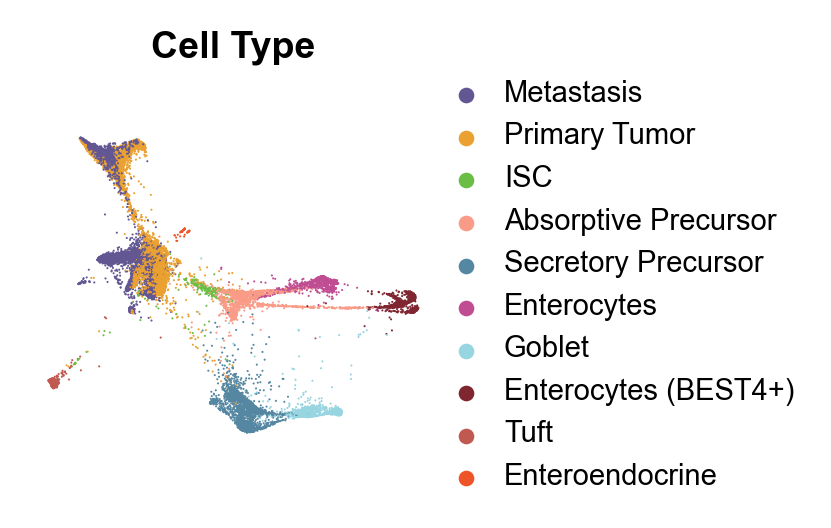

In [4]:
fig = plot_embedding(
    ad_unt,
    'Cell Type',
    basis='X_draw_graph_fa',
    palette=named_colors,
    dim=2,
    s=1,
    rasterized=True,
)
fig.savefig(f'{media_dir}/ed_figure_3a.svg')

## ED Figure 2c. ISC Signature

In [5]:
# Get ISC DEGs obtained with MAST
isc_diffex = pd.read_excel(
    f'{data_dir}/tables/Supplementary_Table_1.xlsx',
    skiprows=1,
    index_col=0,
    sheet_name='c',
)
isc_signature = isc_diffex[isc_diffex['ISC Signature'] == 1].index

In [6]:
ad_unt.X = ad_unt.layers['z-score']
name = 'ISC Signature Notebook'
sc.tl.score_genes(ad_unt, isc_signature, use_raw=False, score_name=name)

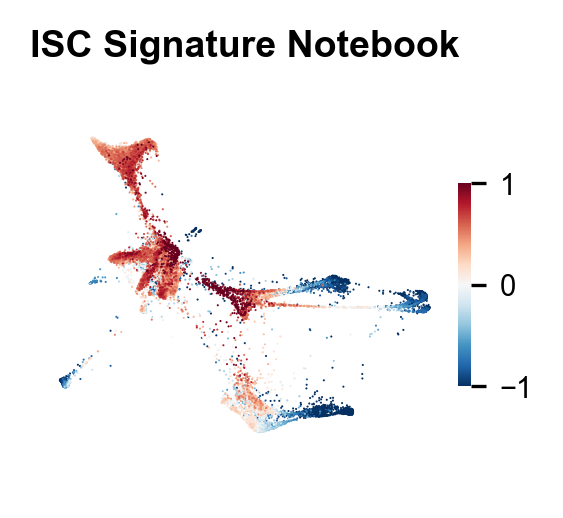

In [7]:
fig = plot_embedding(
    ad_unt,
    'ISC Signature Notebook',
    basis='X_draw_graph_fa',
    palette=named_colors,
    dim=2,
    s=1,
    vmin=-1,
    vmax=1,
    rasterized=True,
    cmap='RdBu_r',
)
fig.savefig(f'{media_dir}/ed_figure_3c.svg')

## ED Figure 3d. ISC signature and PC 1 by cell type

In [110]:
# Order for plot
cell_type_order = [
    'Enterocytes (BEST4+)',  
    'Goblet',
    'Enterocytes',
    'Secretory Precursor',
    'Absorptive Precursor',
    'ISC',
    'Metastasis',
    'Primary Tumor',
]

ad_unt.obs['Cell Type'] = pd.Categorical(
    ad_unt.obs['Cell Type'],
    ordered=True,
    categories=cell_type_order,
)
mask = ad_unt.obs['Cell Type'].isin(cell_type_order)

# Reverse for consistency in order
ad_unt.obs['PC 1'] = -ad_unt.obsm['X_pca'].T[0]

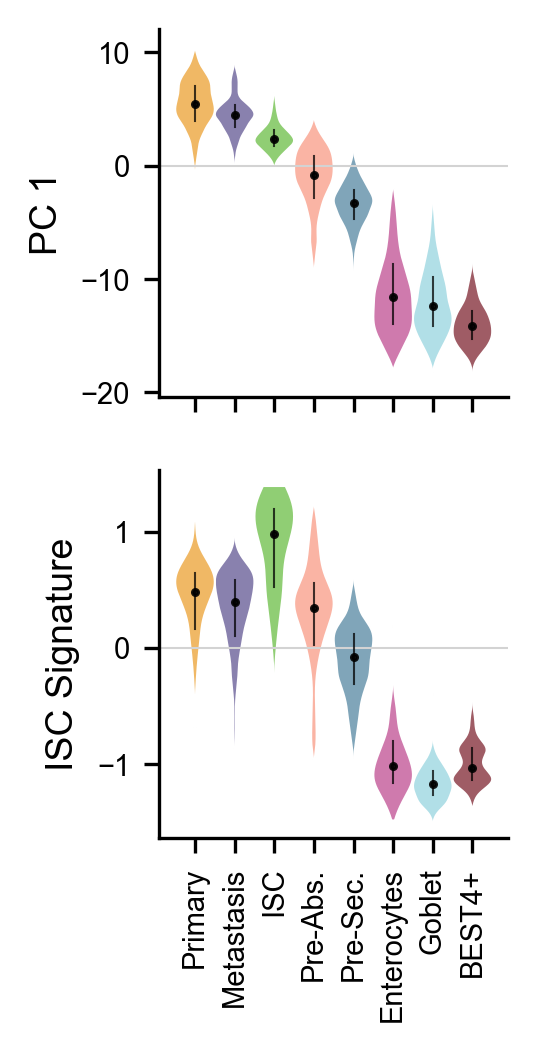

In [111]:
fig, axes = plt.subplots(2, 1, figsize=(1.5, 3.5), sharex=True)

for ax, col in zip(axes.flat, ['PC 1', 'ISC Signature']):
    plot_violin(ad_unt.obs[mask], 'Cell Type', col, named_colors, ax)
    ax.set_ylabel(col)
    ax.axhline(0, lw=0.5, color='lightgray', zorder=1)
    labels = [abbreviations[ct] for ct in cell_type_order]
    ax.set_xticklabels(labels, rotation=90)

fig.savefig(f'{media_dir}/ed_figure_3d.svg')

## ED Figure 3e. Heatmap of ISC Genes

In [112]:
# Get ISC DEGs obtained with MAST
isc_diffex = pd.read_excel(
    f'{data_dir}/tables/Supplementary_Table_2.xlsx',
    skiprows=1,
    index_col=0,
    sheet_name='a',
)
isc_degs = isc_diffex[isc_diffex['ISC DEG'] == 1].index

In [113]:
# Summary data per cell type
pd.DataFrame(
    ad_unt[:, isc_degs].layers["z-score"],
    columns=isc_degs,
).groupby(ad_unt.obs["Cell Type"].values).mean().T

,Enterocytes (BEST4+),Goblet,Enterocytes,Secretory Precursor,Absorptive Precursor,ISC,Metastasis,Primary Tumor
DPEP1,-0.803421,-0.848531,-0.825034,-0.844955,-0.831107,-0.741107,0.723424,0.677376
IGF2,-0.307825,-0.294845,-0.301973,-0.284405,-0.281986,-0.162826,0.485778,0.050724
LY6E,-0.702457,-0.540327,-0.674734,-0.576861,-0.664774,-0.591546,0.122962,0.813756
APCDD1,-0.461608,-0.461344,-0.460779,-0.450176,-0.455002,-0.386258,0.250921,0.477175
RBP1,-0.515080,-0.506894,-0.501202,-0.507083,-0.501595,-0.281687,-0.011971,0.738122
...,...,...,...,...,...,...,...,...
RARRES2,-0.681143,-0.668772,-0.556757,0.613364,1.392418,2.445449,-0.277684,-0.209863
HAGLROS,-0.176360,-0.243110,-0.207463,0.075275,1.629499,2.641997,-0.313485,-0.257190
GREM2,-0.295291,-0.301709,-0.024746,-0.178230,1.451765,2.811194,-0.273404,-0.139714
GP2,-0.290773,-0.330273,-0.291824,0.121983,1.843461,2.298892,-0.301687,-0.267348


In [117]:
# Summary data per cell type
isc_degs_summary = pd.DataFrame(
    ad_unt[:, isc_degs].layers["z-score"],
    columns=isc_degs,
).groupby(ad_unt.obs["Cell Type"].values).mean().T

# Cluster
with HiddenPrints():
    clusters, _, _ = sc.external.tl.phenograph(isc_degs_summary, k=35)

# Reorder heatmap entries
cluster_means = isc_degs_summary.groupby(clusters).mean()
cluster_order = cluster_means['Metastasis'].sort_values().index[::-1]
clusters = pd.Categorical(clusters, categories=cluster_order, ordered=True)
clusters = pd.Series(clusters, index=isc_degs)
def reorder(group):
    lkg = linkage(group, method="single")
    leaves = dendrogram(lkg, no_plot=True)['leaves']
    return group.iloc[leaves]
isc_degs_summary = isc_degs_summary.groupby(clusters).apply(reorder)
isc_degs_summary = isc_degs_summary[cell_type_order]
isc_degs_summary.rename(abbreviations, axis=1, inplace=True)

<Axes: xlabel='None-None'>

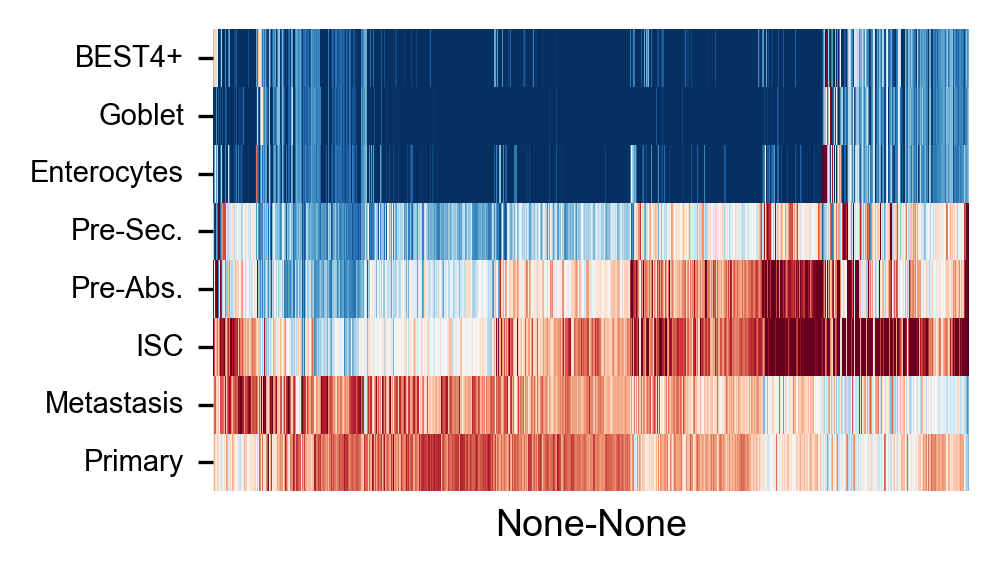

In [118]:
# Draw heatmap
fig, ax = plt.subplots(
    1,1, 
    figsize=(3.25, 2)
)
sns.heatmap(
    isc_degs_summary.T,
    vmin=-1, vmax=1,
    cmap="RdBu_r",
    ax=ax, cbar=False,
    yticklabels=True,
    xticklabels=False,
)

Text(0, 0.5, 'ISC Signature')

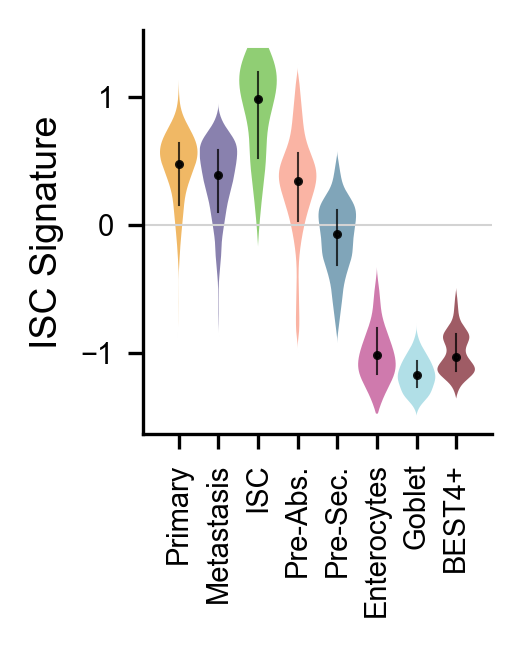

In [241]:
fig, ax = plt.subplots(1,1, figsize = (1.5, 1.75))

plot_violin(ad_unt.obs[mask], 'Cell Type', 'ISC Signature', named_colors, ax)
ax.axhline(0, lw=0.5, color='lightgray', zorder=1)
ax.set_xticklabels([abbreviations[ct] for ct in cell_type_order], rotation=90)
ax.set_ylabel('ISC Signature')
#fig.savefig(f'{media_dir}/ed_figure_3d_top.svg')

Text(0.5, 0, 'DC 1')

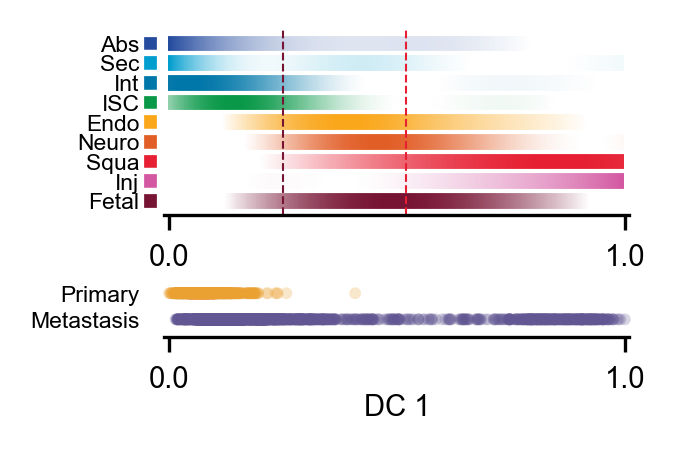

In [50]:
# Features to plot for KG146
modules = [
    'Absorptive Intestine',
    'Secretory Intestine',
    'Intestine',
    'Tumor ISC-like',
    'Endoderm Development',
    'Neuroendocrine',
    'Squamous',
    'Injury Repair',
]
features = [f'Module {m} Score' for m in modules]
features += ['Fetal, Conserved']
peaks = ['Module Squamous Score', 'Fetal, Conserved']

# Plot module progressions
fig = plot_module_progressions(
    ad_146, named_colors, features=features, peaks=peaks, figsize=(2, 1.33)
)

# Additional Formatting
ax = fig.axes[0]
ax.yaxis.set_visible(True)
yticklabels = [abbreviations[m] for m in modules] + ['Fetal']
ax.set_yticks(range(len(yticklabels)), yticklabels)
ax.tick_params(axis='y', length=0, labelsize=5.5, pad=6)

ax = fig.axes[1]
ax.yaxis.set_visible(True)
yticklabels = ['Metastasis', 'Primary']
ax.set_yticks(range(len(yticklabels)), yticklabels)
ax.tick_params(axis='y', length=0, labelsize=5.5, pad=6)
ax.set_xlabel('DC 1', fontsize=7, labelpad=0)

Text(0.5, 0, 'DC 1')

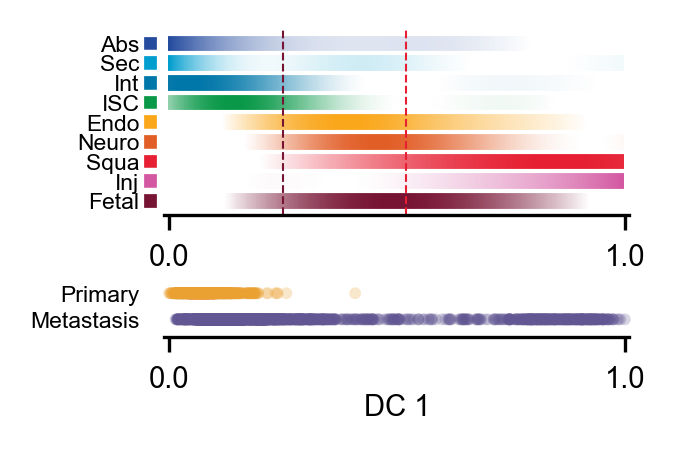

In [50]:
# Features to plot for KG146
modules = [
    'Absorptive Intestine',
    'Secretory Intestine',
    'Intestine',
    'Tumor ISC-like',
    'Endoderm Development',
    'Neuroendocrine',
    'Squamous',
    'Injury Repair',
]
features = [f'Module {m} Score' for m in modules]
features += ['Fetal, Conserved']
peaks = ['Module Squamous Score', 'Fetal, Conserved']

# Plot module progressions
fig = plot_module_progressions(
    ad_146, named_colors, features=features, peaks=peaks, figsize=(2, 1.33)
)

# Additional Formatting
ax = fig.axes[0]
ax.yaxis.set_visible(True)
yticklabels = [abbreviations[m] for m in modules] + ['Fetal']
ax.set_yticks(range(len(yticklabels)), yticklabels)
ax.tick_params(axis='y', length=0, labelsize=5.5, pad=6)

ax = fig.axes[1]
ax.yaxis.set_visible(True)
yticklabels = ['Metastasis', 'Primary']
ax.set_yticks(range(len(yticklabels)), yticklabels)
ax.tick_params(axis='y', length=0, labelsize=5.5, pad=6)
ax.set_xlabel('DC 1', fontsize=7, labelpad=0)

## Figure 2d. Overlaps between modules

In [87]:
# Filter to patients with sufficient cells per sample
sample_sizes = ad_tum.obs.groupby(['Patient', 'Sample Type']).size().unstack()
mask = ad_tum.obs['Patient'].map(sample_sizes.gt(10).all(1))
ad_tum = ad_tum[mask].copy()

In [81]:
# Scores to include in plots
features = [
    'Module Absorptive Intestine Score',
    'Module Secretory Intestine Score',
    'Module Intestine Score',
    'Module Tumor ISC-like Score',
    'Module Endoderm Development Score',
    'Fetal, Conserved',
    'Module Squamous Score',
    'Module Neuroendocrine Score',
]
labels = [x.replace('Module ', '').replace(' Score', '') for x in features]

### Overlaps between modules in *Moorman et al*, KG146, KG182, KG183, KG150

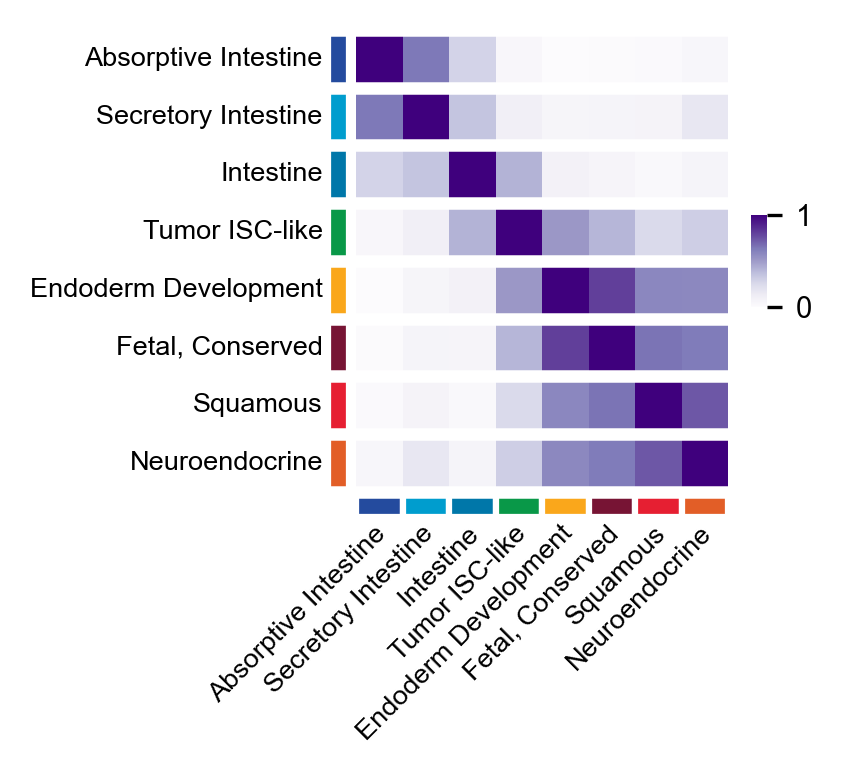

In [82]:
# Plot only for best patients
mask = ad_tum.obs['Patient'].isin([146, 182, 150, 183])
overlaps = get_feature_overlaps(ad_tum[mask], features, 0.75)
fig = plot_overlaps(overlaps, named_colors, labels)
fig.savefig(f'{media_dir}/figure_4d.svg')

### Overlaps between modules in *Moorman et al*, rest

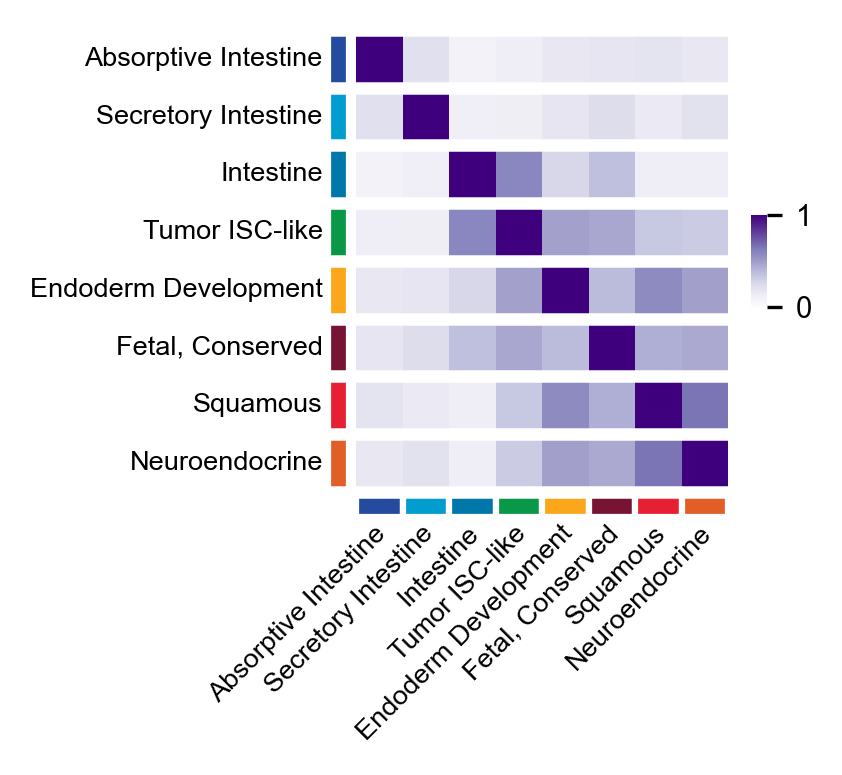

In [83]:
# Plot for patients not in Figure 4
mask = ~ad_tum.obs['Patient'].isin([146, 182, 150, 183])
overlaps = get_feature_overlaps(ad_tum[mask], features, 0.75)
fig = plot_overlaps(overlaps, named_colors, labels)
fig.savefig(f'{media_dir}/figure_4e.svg')

### Overlaps between modules in *Wang et al*

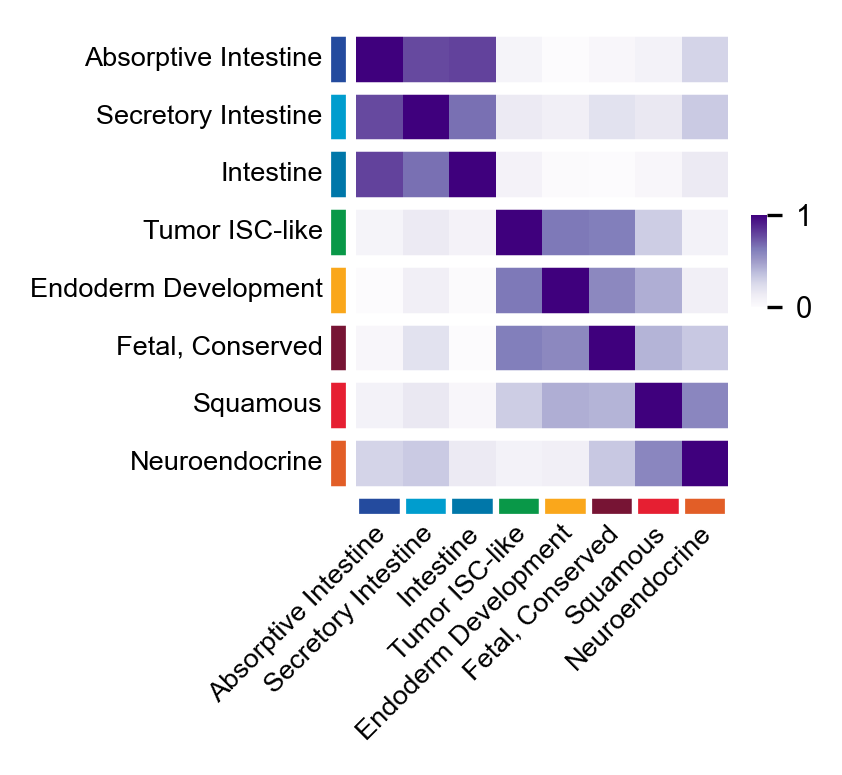

In [67]:
# Plot for Wang et al
overlaps = get_feature_overlaps(ad_wng, features, 0.75)
fig = plot_overlaps(overlaps, named_colors, labels)
fig.savefig(f'{media_dir}/figure_4f.svg')